# Milk Data Classification

### 1. Loading the Dataset

In [55]:
# Imports
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay


In [56]:
milk_data = pd.read_csv('milknew.csv')
milk_data.rename(columns = {"Temprature": "Temperature"}, inplace = True)
milk_data.shape


(1059, 8)

Based on the shape of the data, there are 1059 obersvations with 8 predictors

### 2. Data Preprocessing

In [57]:
milk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           1059 non-null   float64
 1   Temperature  1059 non-null   int64  
 2   Taste        1059 non-null   int64  
 3   Odor         1059 non-null   int64  
 4   Fat          1059 non-null   int64  
 5   Turbidity    1059 non-null   int64  
 6   Colour       1059 non-null   int64  
 7   Grade        1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


We can see all the 7 predictors and 1 response variable. The predictors contains:
- 3 quantitative columns (ph, Temperature, Colour)
- 6 categorical columns (Taste, Odor, Fat, Turbidity)


The response variable 'Grade' contains string data, which should be converted to integer type in order to be used in this analysis

In [58]:
milk_data['Grade'] = milk_data['Grade'].map({'low':0,'medium':1,'high':2})
milk_data.head()

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,2
1,6.6,36,0,1,0,1,253,2
2,8.5,70,1,1,1,1,246,0
3,9.5,34,1,1,0,1,255,0
4,6.6,37,0,0,0,0,255,1


Now we have mapped milk grade as : 
- 'Low' = 0
- 'Medium' = 1
- 'High' = 2 

In [59]:
milk_data.isna().sum()

pH             0
Temperature    0
Taste          0
Odor           0
Fat            0
Turbidity      0
Colour         0
Grade          0
dtype: int64

Our data does not contain any NA values. So we do not need to handle that.

In [60]:
# Correlation
correlation_matrix = milk_data.drop('Grade', axis=1).corr()
correlation_matrix

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour
pH,1.000000,0.244684,-0.064053,-0.081331,-0.093429,0.048384,-0.164565
Temperature,0.244684,1.000000,-0.109792,-0.048870,0.024073,0.185106,-0.008511
Taste,-0.064053,-0.109792,1.000000,0.017582,0.324149,0.055755,-0.082654
Odor,-0.081331,-0.048870,0.017582,1.000000,0.314505,0.457935,-0.039361
Fat,-0.093429,0.024073,0.324149,0.314505,1.000000,0.329264,0.114151
Turbidity,0.048384,0.185106,0.055755,0.457935,0.329264,1.000000,0.136436
Colour,-0.164565,-0.008511,-0.082654,-0.039361,0.114151,0.136436,1.000000


### 3. Data Visualizations

In [61]:
chart_grade_count = alt.Chart(milk_data).mark_bar(size = 30).encode(
    x=alt.X('count()', axis = alt.Axis(titleFontSize = 14)),
    y=alt.Y('Grade', sort='x', axis=alt.Axis(tickMinStep=2, titleFontSize = 14))
).properties(
    height=200,
    width=600
)
chart_grade_count.configure_axis().properties(title= {'text': "The Number of Entries Assocaited with the Response Variable",
            'fontSize': 21.5,
            'offset': 20
           })

alt.Chart(...)

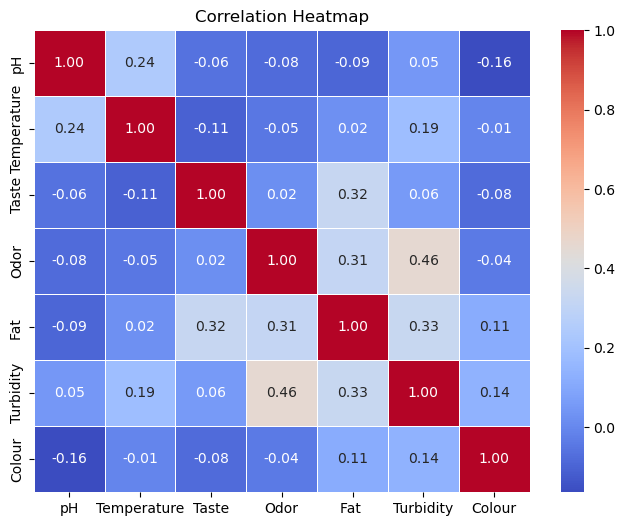

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

This heat map shows the correlation between all the predictor variables. Values close to 1 or -1 are indicative of high correlation and values close to 0 are indicative of low correlation

### 4. Data Standardization and Splitting

We will start by splitting our dataset into X (predictors) and Y (response variable). 

In [63]:
X = milk_data.drop('Grade', axis=1)
y = milk_data['Grade']

- Labels in X (Predictors) : pH, Temperature, Taste, Odor, Fat, Turbidity, Colour 
- Labels in Y (Response Variable) : Grade

Now we will scale our data using StandardScaler :

In [64]:
# Scaling the quantitative features
quantitative_vars = X[["pH", "Temperature", "Colour"]]
sc = StandardScaler()
sc.fit(quantitative_vars)
xscaled=sc.transform(quantitative_vars)

# Creating a new DataFrame with the scaled features
X_scaled=pd.DataFrame(data=xscaled,columns=milk_data.columns[0:3])
X_scaled = pd.concat([X_scaled, X.iloc[:,2:6]], axis = 1)
X_scaled

,pH,Temperature,Taste,Taste,Odor,Fat,Turbidity
0,-0.021531,-0.914107,0.501600,1,0,1,0
1,-0.021531,-0.815035,0.269333,0,1,0,1
2,1.336564,2.553438,-1.356536,1,1,1,1
3,2.051351,-1.013180,0.733867,1,1,0,1
4,-0.021531,-0.715962,0.733867,0,0,0,0
...,...,...,...,...,...,...,...
1054,0.049947,0.076620,-1.124269,1,1,0,0
1055,0.049947,-0.616889,0.733867,1,0,1,0
1056,-2.594765,-0.418744,0.733867,1,1,1,1
1057,0.121426,-0.121525,-0.427468,1,0,1,0


Splitting the data into training and testing set:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 5. Running a Random Forest Analysis on the data

Best parameters:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


Accuracy: 99.52830188679245
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       1.00      1.00      1.00        86
           2       0.98      1.00      0.99        48

    accuracy                           1.00       212
   macro avg       0.99      1.00      0.99       212
weighted avg       1.00      1.00      1.00       212



Feature Importance:
       Feature  Importance
0           pH    0.400665
1  Temperature    0.233980
6       Colour    0.091174
5    Turbidity    0.083575
4         Fat     0.082294
2        Taste    0.060834
3         Odor    0.047478


Confusion Matrix:


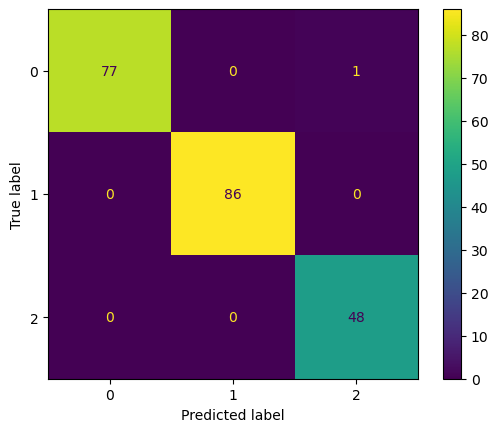

In [66]:
from sklearn.ensemble import RandomForestClassifier

# Grid Search
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 5, 10],
    'min_samples_split': [2, 5, 10]
}

model_rf = RandomForestClassifier()

randomforest_grid = GridSearchCV(model_rf, param_grid, cv=5)
randomforest_grid.fit(X_train, y_train)

# print best parameters from grid search
print("Best parameters:")
print(randomforest_grid.best_params_) 
print("\n")

# Fit model with best parameters
best_rf_model = randomforest_grid.best_estimator_
best_rf_model.fit(X_train, y_train)

# print accuracy score
randomforest_predictions = best_rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, randomforest_predictions) * 100
print("Accuracy:", rf_acc)
print("\n")

# print classification report
print("Classification Report:")
print(classification_report(y_test, randomforest_predictions))
print("\n")

# print variable priority
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance_df)
print("\n")

# plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, randomforest_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


### 6. Running a Decision Tree

Best parameters:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}


Accuracy: 99.05660377358491
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        78
           1       1.00      1.00      1.00        86
           2       0.98      0.98      0.98        48

    accuracy                           0.99       212
   macro avg       0.99      0.99      0.99       212
weighted avg       0.99      0.99      0.99       212



Feature Importance:
       Feature  Importance
0           pH    0.535061
4         Fat     0.153491
1  Temperature    0.113496
5    Turbidity    0.079743
2        Taste    0.079023
3         Odor    0.035683
6       Colour    0.003503


Confusion Matrix:


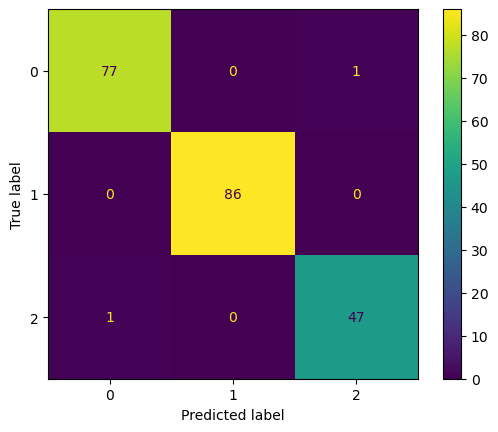

In [75]:
from sklearn.tree import DecisionTreeClassifier

# Grid Search
param_grid = {
    'criterion': ['gini'],
    'max_depth': [1, 5, 10],
    'min_samples_split': [2, 5, 10]
}

model_dt = DecisionTreeClassifier()

decisiontree_grid = GridSearchCV(model_dt, param_grid, cv=5)
decisiontree_grid.fit(X_train, y_train)

# print best parameters from grid search
print("Best parameters:")
print(decisiontree_grid.best_params_) 
print("\n")

# Fit model with best parameters
best_dt_model = decisiontree_grid.best_estimator_
best_dt_model.fit(X_train, y_train)

# print accuracy score
decisiontree_predictions = best_dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, decisiontree_predictions) * 100
print("Accuracy:", dt_acc)
print("\n")

# print classification report
print("Classification Report:")
print(classification_report(y_test, decisiontree_predictions))
print("\n")

# print variable priority
feature_importances = best_dt_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance_df)
print("\n")

# plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, decisiontree_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


### 7. Running a Multinomial Logistic Regression

Best parameters:
{'C': 1, 'multi_class': 'multinomial', 'solver': 'lbfgs'}


Accuracy: 83.9622641509434


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        78
           1       0.93      0.83      0.88        86
           2       0.68      0.79      0.73        48

    accuracy                           0.84       212
   macro avg       0.83      0.83      0.83       212
weighted avg       0.85      0.84      0.84       212



Confusion Matrix:


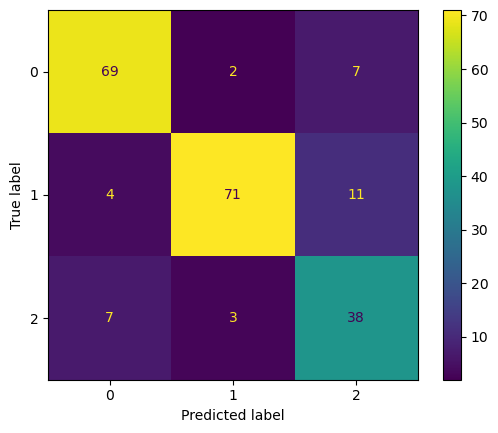

In [103]:
from sklearn.linear_model import LogisticRegression

# Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'multi_class': ['multinomial'],
    'solver': ['lbfgs', 'sag', 'newton-cg']
}

model_mnlr = LogisticRegression(max_iter = 1000)

mnlr_grid = GridSearchCV(model_mnlr, param_grid, cv=5)
mnlr_grid.fit(X_train, y_train)

# print best parameters from grid search
print("Best parameters:")
print(mnlr_grid.best_params_) 
print("\n")

# Fit model with best parameters
best_mnlr_model = mnlr_grid.best_estimator_
best_mnlr_model.fit(X_train, y_train)

# print accuracy score
mnlr_predictions = best_mnlr_model.predict(X_test)
mnlr_acc = accuracy_score(y_test, mnlr_predictions) * 100
print("Accuracy:", mnlr_acc)
print("\n")

# print classification report
print("Classification Report:")
print(classification_report(y_test, mnlr_predictions))
print("\n")

# plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, mnlr_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### 8. Running Linear Discriminant Analysis

Best parameters:
{'shrinkage': None, 'solver': 'svd'}


Accuracy: 75.47169811320755
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.76        78
           1       0.79      0.90      0.84        86
           2       0.58      0.60      0.59        48

    accuracy                           0.75       212
   macro avg       0.73      0.73      0.73       212
weighted avg       0.76      0.75      0.75       212



Coefficients of Linear Discriminants:
[[-2.57848511e-01  1.09032199e+00  3.51916401e-01  6.55257026e-01
   2.30028595e-02 -6.04517078e-05  1.44091252e+00]
 [ 4.38541167e-02 -1.07273388e+00 -6.44327953e-01 -1.05657949e+00
  -1.25293626e+00 -1.14257154e+00 -1.61949980e+00]
 [ 3.74398278e-01 -3.54594515e-01  2.98287469e-01  3.57209989e-01
   1.69601749e+00  1.58212415e+00 -1.89155528e-01]]


Confusion Matrix:


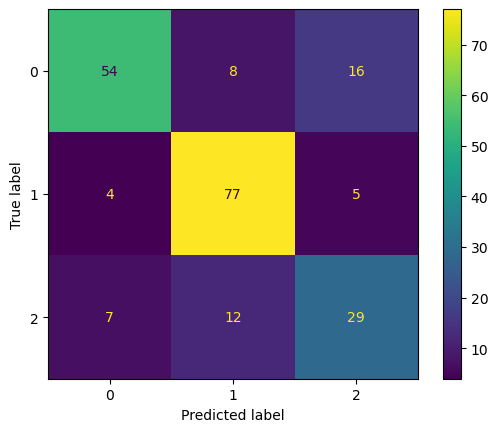

In [101]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Grid search
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None]
}

model_lda = LinearDiscriminantAnalysis()

lda_grid = GridSearchCV(model_lda, param_grid, cv=5)
lda_grid.fit(X_train, y_train)

# print best parameters from grid search
print("Best parameters:")
print(lda_grid.best_params_) 
print("\n")

# Fit model with best parameters
best_lda_model = lda_grid.best_estimator_
best_lda_model.fit(X_train, y_train)

# print accuracy score
lda_predictions = best_lda_model.predict(X_test)
lda_acc = accuracy_score(y_test, lda_predictions) * 100
print("Accuracy:", lda_acc)

# print classification report
print("Classification Report:")
print(classification_report(y_test, lda_predictions))
print("\n")

# print coefficients of linear discriminants
print("Coefficients of Linear Discriminants:")
print(best_lda_model.coef_)
print("\n")

# plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, lda_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### 9. Running kNN

Best parameters:
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


Accuracy: 99.52830188679245
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       1.00      1.00      1.00        86
           2       0.98      1.00      0.99        48

    accuracy                           1.00       212
   macro avg       0.99      1.00      0.99       212
weighted avg       1.00      1.00      1.00       212



Confusion Matrix:


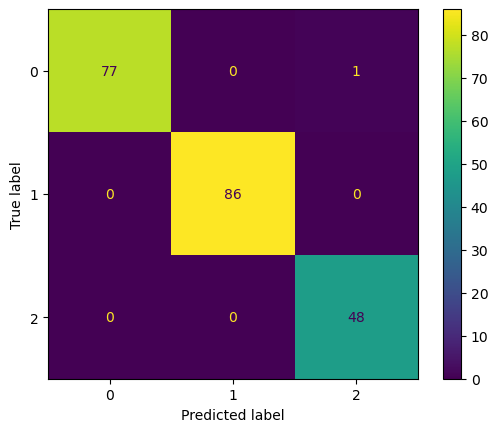

In [100]:
from sklearn.neighbors import KNeighborsClassifier

# Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],         
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50],           
    'p': [1, 2] 
}

model_knn = KNeighborsClassifier()

knn_grid = GridSearchCV(model_knn, param_grid, cv=5)
knn_grid.fit(X_train, y_train)

# print best parameters from grid search
print("Best parameters:")
print(knn_grid.best_params_) 
print("\n")

# Fit model with best parameters
best_knn_model = knn_grid.best_estimator_
best_knn_model.fit(X_train, y_train)

# print accuracy score
knn_predictions = best_knn_model.predict(X_test)
knn_acc = accuracy_score(y_test, knn_predictions) * 100
print("Accuracy:", knn_acc)

# print classification report
print("Classification Report:")
print(classification_report(y_test, knn_predictions))
print("\n")

# plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, knn_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()